In [1]:
from HTML import config as Config
from HTML.dataset import *
from HTML.config import ratio, nominal, ordinal, meaningless
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from HTML import preprocessing as ps
%matplotlib inline

In [2]:
x_train = pd.read_csv(Config.train_path)
x_train = ps.preprocessing(x_train)
x_train = x_train.drop(['company', 'agent'], axis=1)
x_train.head()

,ID,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,...,C,3,No Deposit,0,Transient,-6.305161,0,0,Check-Out,2015-07-01
1,1,City Hotel,0,257,2015,July,27,1,0,2,...,A,1,No Deposit,0,Transient,75.052227,0,0,Check-Out,2015-07-03
2,2,City Hotel,0,257,2015,July,27,1,0,2,...,A,0,No Deposit,0,Transient,74.546401,0,0,Check-Out,2015-07-03
3,3,City Hotel,0,257,2015,July,27,1,0,2,...,A,0,No Deposit,0,Transient,76.376288,0,0,Check-Out,2015-07-03
4,4,City Hotel,0,257,2015,July,27,1,0,2,...,A,0,No Deposit,0,Transient,49.411647,0,0,Check-Out,2015-07-03


In [3]:
x_train.columns

Index(['ID', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [4]:
x_train['is_canceled'].value_counts()

0    58771
1    32756
Name: is_canceled, dtype: int64

In [5]:
dummies = pd.get_dummies(
        data=x_train[set(x_train.columns) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled'}],
        columns=set(nominal+ordinal) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'company', 'agent'},
        drop_first=True,
        dummy_na=True)
dummies = dummies[sorted(set(dummies.columns) - {'index', 'ID'} - set(meaningless))]

In [6]:
x = dummies[sorted([c for c in dummies.columns if 'reservation_status' not in c])].to_numpy()
# fact = pd.factorize(x_train['is_canceled'])
y = x_train['is_canceled'].to_numpy()

In [7]:
x.shape

(91527, 323)

In [8]:
y.shape

(91527,)

In [9]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [10]:
def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]

    return sample_weights

In [11]:
largest_class_weight_coef=np.max(np.bincount(y)) / len(y)
weights = CreateBalancedSampleWeights(y, largest_class_weight_coef=largest_class_weight_coef)

In [12]:
s = []
from sklearn.tree import DecisionTreeClassifier
for i in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    clf = DecisionTreeClassifier(random_state=130, max_depth = i)
    scores = cross_val_score(clf, x, y, cv=5, scoring='f1', verbose=1, n_jobs=2)
    s.append(scores)
    print(np.mean(scores))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   14.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.7065497844693758


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   13.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.7242940400505591


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   15.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.7306157345682363


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   15.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.7552142848039873


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   17.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.7521718860308929


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   17.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.749933533356771


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   19.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.7380446100978573


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.7400612297512328


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   20.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.7384965927616987


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   19.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.7362998678216464
0.7350834648215078


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   21.0s finished


ValueError: x and y must have same first dimension, but have shapes (6,) and (11,)

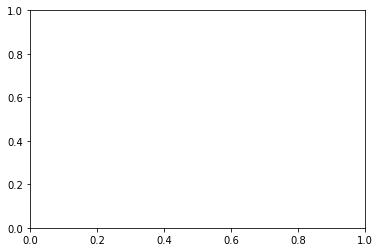

In [13]:
plt.plot([1,5,10,50,100,500], np.mean(np.array(s),axis=1))

In [ ]:
np.mean(np.array(s),axis=1)

In [ ]:
clf = XGBClassifier(
    objective='binary:logistic',
    n_estimators=10,
    learning_rate=.3,
    max_depth=6,
    subsample=.3,
    n_jobs=6,
    colsample_bytree=.9,
    random_state=1126,
    gamma=10
)

In [ ]:
clf

In [ ]:
clf.fit(x, y)

In [ ]:
pred = clf.predict(x)

In [ ]:
mat = np.zeros((3,3))
for p, a in zip(pred, y):
    mat[p, a] += 1

In [ ]:
p

In [ ]:
mat